<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [2]:
import glob
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from numpy.random import randint

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio

import random
from skimage.transform import rescale

# Importing dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Preprocessing

In [7]:
import cv2
import os
import random
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from skimage.transform import rescale
import matplotlib.pyplot as plt

n = 100
lr_images = []
hr_images = []

lr_dir = "/content/drive/MyDrive/research_dataset/BSD100"
hr_dir = "/content/drive/MyDrive/research_dataset/BSD100"

common_width = 256
common_height = 256

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

for img_name in os.listdir(lr_dir)[:n]:
    img_path = os.path.join(lr_dir, img_name)
    img_lr = cv2.imread(img_path)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = resize_image(img_lr, common_width, common_height)
        lr_images.append(img_lr)
    else:
        print(f"Failed to read image: {img_path}")

for img_name in os.listdir(hr_dir)[:n]:
    img_path = os.path.join(hr_dir, img_name)
    img_hr = cv2.imread(img_path)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = resize_image(img_hr, common_width, common_height)
        hr_images.append(img_hr)
    else:
        print(f"Failed to read image: {img_path}")

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

# Image Plotting

This block randomly selects an image from lr_images, upscales it using bicubic interpolation, and then displays the original LR image, HR image, and the upscaled LR image.

Bicubic interpolation is a method used in image processing and computer graphics to interpolate or estimate pixel values in an image at locations that are not explicitly defined by the original image data. It's particularly useful when scaling or resizing images, as it produces smoother and more visually pleasing results compared to simpler interpolation methods like nearest neighbor or bilinear interpolation.

<ipython-input-8-4483f8f0f08e>:5: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)


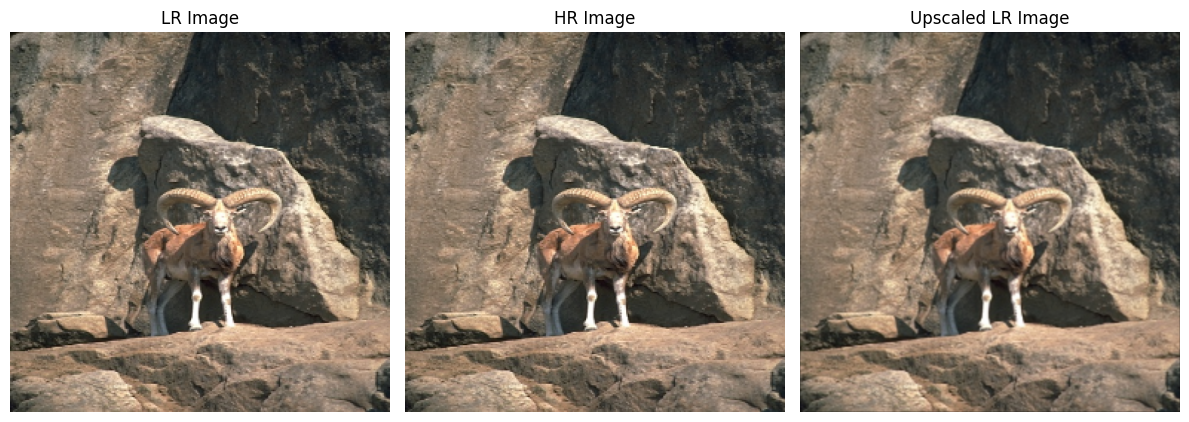

In [8]:
# Randomly select an image number
image_number = random.randint(0, len(lr_images) - 1)

# Upscale the LR image using bicubic interpolation
upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)

# Set up the figure
plt.figure(figsize=(12, 6))

# Display LR image
plt.subplot(131)
plt.title('LR Image')
plt.imshow(lr_images[image_number])
plt.axis('off')

# Display HR image
plt.subplot(132)
plt.title('HR Image')
plt.imshow(hr_images[image_number])
plt.axis('off')

# Display Upscaled LR image
plt.subplot(133)
plt.title('Upscaled LR Image')
plt.imshow(upscaled_lr_image)
plt.axis('off')

plt.tight_layout()
plt.show()


# PSNR value

The Peak Signal-to-Noise Ratio (PSNR) is a metric used to quantify the quality of an image reconstruction or restoration process by measuring the difference between the original image and its approximation.

In [22]:
# Resize HR image and LR image to a common dimension
hr_image_resized = cv2.resize(hr_images[image_number], (lr_images[image_number].shape[1], lr_images[image_number].shape[0]))

# Ensure consistency in number of channels
hr_image_resized = cv2.cvtColor(hr_image_resized, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed

# Check the number of channels in upscaled_lr_image
print("Upscaled LR Image Channels:", upscaled_lr_image.shape[2])

# If upscaled_lr_image has 12 channels, reduce it to 3 channels
if upscaled_lr_image.shape[2] == 12:
    upscaled_lr_image = upscaled_lr_image[:, :, :3]

# Resize upscaled_lr_image to match hr_image_resized dimensions if needed
if hr_image_resized.shape != upscaled_lr_image.shape:
    upscaled_lr_image = cv2.resize(upscaled_lr_image, (hr_image_resized.shape[1], hr_image_resized.shape[0]))

# Calculate PSNR for LR vs. HR
psnr_lr_hr = peak_signal_noise_ratio(hr_image_resized, lr_images[image_number], data_range=hr_image_resized.max() - hr_image_resized.min())

# Calculate PSNR for Upscaled LR vs. HR
psnr_upscaled_lr_hr = peak_signal_noise_ratio(hr_image_resized, upscaled_lr_image, data_range=hr_image_resized.max() - hr_image_resized.min())

# Calculate PSNR for Upscaled LR vs. LR
psnr_upscaled_lr_lr = peak_signal_noise_ratio(lr_images[image_number], upscaled_lr_image, data_range=lr_images[image_number].max() - lr_images[image_number].min())

# Print PSNR values
print("PSNR LR vs. HR:", psnr_lr_hr)
print("PSNR Upscaled LR vs. HR:", psnr_upscaled_lr_hr)
print("PSNR Upscaled LR vs. LR:", psnr_upscaled_lr_lr)

Upscaled LR Image Channels: 3
PSNR LR vs. HR: 16.390791911081905
PSNR Upscaled LR vs. HR: 7.182458310727239
PSNR Upscaled LR vs. LR: 7.180494473071858


# Model Generation

# Data Preparation

In [26]:
#Scale values
lr_images = lr_images/255
hr_images = hr_images/255

In [27]:
#Train test Split
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images,hr_images,test_size=0.3,random_state=100)

low_resolution_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
high_resolution_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

In [28]:
# Shape of low-resolution and high-resolution images
input_low_resolution = Input(shape=low_resolution_shape)
input_high_resolution = Input(shape=high_resolution_shape)

In [29]:
print("Low-resolution train images shape:", lr_train.shape)
print("High-resolution train images shape:", hr_train.shape)
print("Low-resolution test images shape:", lr_test.shape)
print("High-resolution test images shape:", hr_test.shape)

Low-resolution train images shape: (70, 256, 256, 3)
High-resolution train images shape: (70, 256, 256, 3)
Low-resolution test images shape: (30, 256, 256, 3)
High-resolution test images shape: (30, 256, 256, 3)


# Residual Block

Residual Block is used to overcome the degradation problem which means when we add more layers, the performance of the network gets worse instead of better.

In [30]:
def residual_block(x):
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size,strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size,strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    return res

# Generator Network
commonly used in tasks like image super-resolution or image-to-image translation. Here with a combination of convolutional, residual, upsampling, and activation layers to transform input data into a desired output, such as high-resolution images.


In [31]:
def build_generator(gen_input):

    residual_blocks = 16
    momentum = 0.8
    # Input Layer of the generator network
    input_layer = gen_input

    # Adding the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same',activation='relu')(input_layer)

    # Adding 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Adding the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Adding an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Adding another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1,
                  padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output],
                  name='generator')
    return model

In [32]:
generator = build_generator(input_low_resolution)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         15616     ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
                                                                                          

# Discriminator Network

 discriminator network is designed to classify images as real or fake. It achieves this by applying convolutional operations to extract features from the input images and then using dense layers for classification. The use of LeakyReLU activation functions helps in preventing the network from getting stuck during training, and batch normalization aids in stabilizing the training process.


In [33]:
def build_discriminator(dis_input):

    leakyrelu_alpha = 0.2
    momentum = 0.8

    input_layer = dis_input

    # Adding the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Adding the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Adding the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Adding the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Adding the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Adding the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Adding the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Adding the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Adding a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [34]:
common_optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator(input_high_resolution)
discriminator.compile(loss='mse', optimizer=common_optimizer,
                      metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_33 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                     

# VGG19 Network

In [35]:
def build_vgg(high_resolution_shape):
    vgg = VGG19(weights = 'imagenet', include_top=False, input_shape=high_resolution_shape)

    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

def create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution):
    generated_high_resolution_images = generator(input_low_resolution)

    features = vgg(generated_high_resolution_images)

    discriminator.trainable = False

    probs = discriminator(generated_high_resolution_images)

    adversarial_model = Model(inputs=[input_low_resolution, input_high_resolution], outputs=[probs, features])

    return adversarial_model

In [36]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

# Adversial Network
the adversarial model combines the generator, discriminator, and VGG network. The generator aims to produce high-resolution images from low-resolution inputs, while the discriminator evaluates the generated images. The VGG network helps to capture the content of the generated images. During training, the discriminator's weights are fixed to focus on improving the generator's performance.


In [37]:
def build_adversarial_model(generator, discriminator, vgg):

    input_low_resolution = Input(shape=(64, 64, 3))

    fake_hr_images = generator(input_low_resolution)
    fake_features = vgg(fake_hr_images)

    discriminator.trainable = False

    output = discriminator(fake_hr_images)

    model = Model(inputs=[input_low_resolution],
                  outputs=[output, fake_features])

    for layer in model.layers:
        print(layer.name, layer.trainable)

    return model

In [38]:
adv_model = build_adversarial_model(generator,discriminator,vgg)
adv_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
adv_model.summary()

input_4 True
generator True
discriminator False
model False
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 generator (Functional)      (None, 1024, 1024, 3)        2042691   ['input_4[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 16, 16, 1)            5219137   ['generator[0][0]']           
                                                                                                  
 model (Functional)          (None, 32, 32, 256)          2325568   ['generator[0][0]']           
                                

# GAN (Generative Adversial Network)

In [39]:
gan_model = create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 1024, 1024, 3)        2042691   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 16, 16, 1)            5219137   ['generator[1][0]']           
                                                                                            

# Saving Model

In [40]:
generator.save('gen_e_10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load Model

In [41]:
generator = load_model('gen_e_10.h5', compile=False)

1/1 [==============================] - 42s 42s/step


<ipython-input-43-ead5deafc663>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


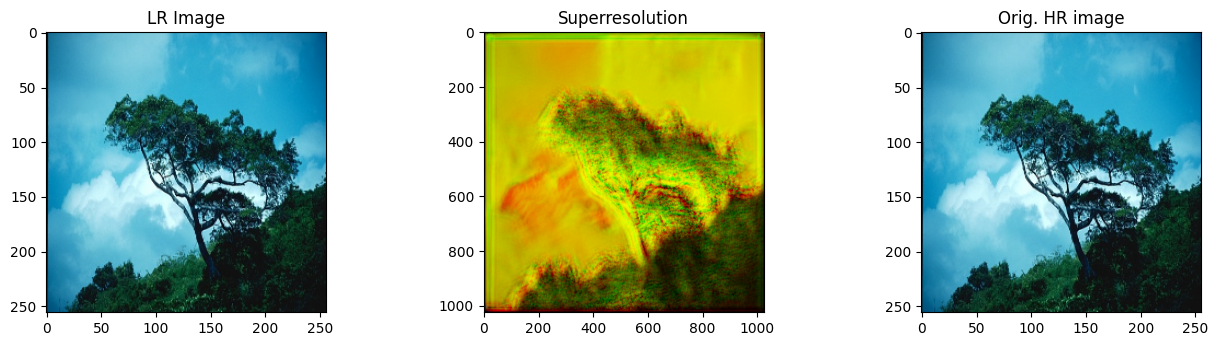

In [43]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.title('Random image')
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
from numpy.random import randint
import numpy as np
import cv2

# Assuming lr_test and hr_test are lists of images
[X1, X2] = [lr_test, hr_test]

# Select a random example index
ix = randint(0, len(X1), 1)[0]  # Use [0] to get the integer index

# Extract the corresponding LR and HR images using the random index
src_image, tar_image = X1[ix], X2[ix]

# Add the batch dimension to the images
src_image = np.expand_dims(src_image, axis=0)
tar_image = np.expand_dims(tar_image, axis=0)

# Generate the super-resolution image from the LR image using your generator model
gen_image = generator.predict(src_image)

# Ensure all images have the same dimensions and are in the range [0, 255]
src_image = src_image.astype(int)
gen_image = gen_image.astype(int)
tar_image = tar_image.astype(int)

# Print the shapes of the images for verification
print("LR Image Shape:", src_image[0].shape)
print("Generated Image Shape:", gen_image[0].shape)
print("Target Image Shape:", tar_image[0].shape)

# Check if the dimensions of gen_image[0] and tar_image[0] are compatible for resizing
if gen_image[0].shape[:2] != tar_image[0].shape[:2]:
    print("Dimensions of the generated image and target image are not compatible for resizing.")
else:
    # Resize the generated image to match the target image's size
    resize_factor = tar_image.shape[1] / gen_image.shape[1]  # Assuming dimensions are compatible
    gen_image_resized = cv2.resize(gen_image[0], None, fx=resize_factor, fy=resize_factor, interpolation=cv2.INTER_LINEAR)


    # Calculate PSNR values
    psnr_lr_image = peak_signal_noise_ratio(src_image[0], tar_image[0], data_range=255)
    psnr_gen_image = peak_signal_noise_ratio(gen_image_resized, tar_image[0], data_range=255)
    psnr_hr_image = peak_signal_noise_ratio(tar_image[0], tar_image[0], data_range=255)  # PSNR with itself should be infinite

    # Display images and PSNR values
    plt.figure(figsize=(16, 8))
    plt.suptitle('Random Image and PSNR Values')
    plt.subplot(231)
    plt.title(f'LR Image (PSNR: {psnr_lr_image:.2f} dB)')
    plt.imshow(src_image[0])
    plt.subplot(232)
    plt.title(f'Superresolution Image (PSNR: {psnr_gen_image:.2f} dB)')
    plt.imshow(gen_image_resized)
    plt.subplot(233)
    plt.title(f'Original HR Image (PSNR: {psnr_hr_image:.2f} dB)')
    plt.imshow(tar_image[0])
    plt.show()


In [ ]:
sreeni_lr = cv2.imread("/content/drive/MyDrive/research_dataset/BSD100/126007.png")
sreeni_hr = cv2.imread("/content/drive/MyDrive/research_dataset/BSD100/126007.png")

sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.title('Generator model image')
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

Both sets of images serve the purpose of visually comparing the output of the super-resolution model, which is the generated high-resolution image, with the original high-resolution image. This comparison is crucial for evaluating how effectively the super-resolution model has reconstructed fine details in high resolution from the initially low-resolution input. The second set, however, focuses more specifically on a manually selected low-resolution image, allowing for a targeted assessment of the super-resolution model's performance with that particular input.